* updated 18 Jan 2025, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 3301 "Data Analysis in Ocean Sciences" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/academic-notes/tree/master/OCES3301_data_analysis_ocean) page.

In [1]:
# load some deafult packages

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

---------------------------

# 05: Statistical tests

***Given a control group and a test group, where you do something only to the test group, what effect does it have, and is it significant?*** This kind of question shows up frequently, such as in drug treatments, dietary studies, life and population sciences (e.g. how do phytoplankton response to external stimuli such as light), studies of cursedness in animals, and many other scientific fields. While there are plausible reasons to explain certain phenomena (e.g. cursedness of animal enabled by cameras), there are also unknowns that sometimes we do not or cannot account for (e.g. cursedness is in the eye of the beholder). Different people might rate cursedness of the following slightly differently.

<img src="https://i.imgur.com/4nCyQjC.jpg" width="400" alt='cerberus'> <img src="https://i.imgur.com/NdL4uiu.jpg" width="400" alt='cursed doggo'>

The problem here is that there is always spread in the data (codified by the **pdf**; see later) and **noise** (or stochasticity), so that makes the experimental and/or observation results fuzzy, and we want ways to pick out the real effects and be confident that we are not making conclusions of the noise. These kind of issues occur even if some of the questions could be answered deterministically in some sense (e.g. observing gravitational waves or the Higgs boson, which have been predicted to exist from theoretical considerations). The below content gives a rather condensed overview of this.

## Disclaimer + some personal experiences with statistical testing

I find the statistical testing stuff ***HARD***, not so much the technical aspect, but certainly the ***conceptual*** ones. I have personally tried to learn this stuff in a dedicated maybe three times since school, first as a A-level student during the final years of secondary school (this kind of stuff was standard in the then statistics modules), somewhat during my undergrad degree (one practice course, but really the more pure side of probability theory), and then for preparing this course through self-study. Instead of hating this stuff, now I at least tolerate it, though I will not say I find the content particularly easy to present: these two notebooks on statistical testing probably took about the same time to write than the rest of the course put together.

For me personally, I think I found the statistical things hard because:

1) For a long time I could not see how the procedures I get taught links up with the problems the procedures are supposed to tackle.

2) I couldn't see what could could go wrong if you didn't follow the recipe, and if you go wrong how do you go about fixing it (I have to say I was somewhat taught through the *"follow the recipe, don't think about it and everything will be alright"* mantra, which I have tried very hard to push against in writing this course).

3) I didn't have enough practice with it (since I don't really use this stuff in my work).

All three factors of course multiply each other: I couldn't see why we were doing it, I didn't know when I went wrong, and I didn't have enough practice (or the need to do so) to begin to see why it needs to be done in a certain way, and the symptoms of when it goes wrong.

A turning point for me is was when I had to prepare for this course and went through [David Speigelhalter](https://en.wikipedia.org/wiki/David_Spiegelhalter)'s book ["The Art of Statistics"](https://www.goodreads.com/book/show/43722897-the-art-of-statistics). Beyond it being actually quite an entertaining read (because the case studies are actually really interesting, and I am being completely serious here!), the layout of that book really does try to pose the problems first, attack it with the tools, and highlight on the way why it matters certain things are done a certain way.

This course is not a statistics course, and I am not trying to be reproduce the things that are already in excellent books (see some of the ones recommended in this course). The thing I will aim to try and do is to link *concepts* to *practice* (in this case with code right next to the descriptive text), dispense with a lot of the formalism and rigour (I hope I haven't overdone it), and I will do my best to highlight the *banana skins*, i.e. where you can go wrong, and what happens if you do.

<img src="https://i.imgur.com/AJl48yc.jpg" width="400" alt='cursed banana'>

(Be careful of banana skins, particularly cursed ones)

## Technical disclaimers

1) I am going to use some probability theory to talk about things, with appropriate refreshers if you have not seen these before. There will be complicated looking integrals involved, but the main thing to bear in mind is that most of those integrals are going to be evaluated numerically, enabled by the `scipy.stat` packages, and in the end you only care about one or two numbers that result.

2) Since probability is involved, there really should be some discussion about the **frequentist** and **Bayesian** viewpoint, which does affect the interpretation, but there won't be. Just be aware there is that rather subtle but important banana skin lying around. The discussion and interpretations below will take the *frequentist* viewpoint.

> NOTE: I personally favour the *Bayesian* viewpoint and find it much more intuitive and satisfactory (maybe because then I can rely on mathematical equations much more readily to think about things).

3) When I get to hypothesis testing, there is the debate of whether one should use the [Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) or the [Pearson](https://en.wikipedia.org/wiki/Egon_Pearson)-[Neyman](https://en.wikipedia.org/wiki/Jerzy_Neyman) formulation. I am going to use mix-and-match in the presentation below (which I gather is now standard practice), and I am not going to be explicit of what bits I am using are from where, because I think it convolutes the arguments somewhat. Look this up on [Wikipedia](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing) if you like.

4) While a lot of focus is traditionally on the analysis part of the hypotheses testing, in fact the **experimental design** and what kind of questions you set up for yourself really is much more important: no matter how much of a analysis wizard you can be, if the experiment was poorly designed in the first place you are probably dead from the onset. The designed aspect is also one very big and important banana skin that we are not really going to touch on below, but you should absolutely be aware of it.

5) I am only going to focus on four tests (Z-test, $t$-test, $F$-test, and $\chi^2$ test). There are many others, each with their own assumptions, but these ones illustrate a lot of the common points and pitfalls, and if you know how these things work in principle you can extend accordingly (on the assumption that the principles were learnt well). The thing you should bear in mind is to choose the test according to the assumptions. The thing ***you should absolutely not do*** is to keep trying different tests on the same data until you get the result you want. ***DON'T DO IT***: this is like torturing the data until it confesses and is extremely bad practice, when the issue is more likely to be because of experimental design or the hypothesis being tested.

---------------------------
# a) Some probability

With that in mind, lets start with some terminology so we can use it to set the scene. The **probability** $p$ of an event $X$ is, loosely speaking, a number that is assigned to the likelihood of the event happening. By convention $p$ is some real number between and including 0 and 1, with $p(X)=1$ denoting something will certainly happen, while $p(X)=0$ means something will never happen. The probability of all possible events should add up to 1.

> NOTE: $X$ was previously denoted a random variable, which is a map that takes set in the sample space to the measurable space, while $p$ is a map from the measurable space to the [0,1] interval, but I digress...

## Example: a coin

An easy way to think about this is again with a simple example, such as flipping of a fair two-sided coin once. The possible outcomes are $H$eads or $T$ails. The coin is fair, so the two cases are equally likely and add up to 1, so each event should be assigned a probability of $p=0.5$. 

Does that mean if we do some coin tosses we should get exactly half each? The answer is no, but you could try it experimentally. Rather than doing a lot of coin tosses, the code below simulates coin tosses and prints out the outcome.

In [2]:
def heads_or_tails(p=0.5):
    """returns a heads (as 1) or tails (as 0), assumes fair coin (so p = 1/2)
         (this is a very verbose way of doing it, you can in principle do it much more consisely)
    """
    a = np.random.rand()  # calls from a uniform distribution
    if a > p:
        return 1  # heads
    else:
        return 0  # tails

n = 10                           # flip n times
rolls = np.zeros(n, dtype=int)   # force output to be integers
for i in range(n):
    rolls[i] = heads_or_tails()
print(rolls)

# Q: why does this actually do and explain why this works
n_heads, n_tails = np.sum(rolls == 1), np.sum(rolls == 0)

print(f"number of heads = {n_heads}, experimental probability is {n_heads / n:.3f}")
print(f"number of tails = {n_tails}, experimental probability is {n_tails / n:.3f}")

[0 0 1 1 1 0 0 0 0 1]
number of heads = 4, experimental probability is 0.400
number of tails = 6, experimental probability is 0.600


> <span style="color:red">**Q.**</span> Describe the code above and explain what it is doing.

While we expect the probability of each event to be 0.5, the numerical outcome in this case probably deviates from that (you can make it reproducible by specifying the RNGesus `seed`). The experiments themselves in this case probably deviates from the **expectation**. Just like there is while there is a sample mean, the samples do not completely correspond to the mean.

> NOTE: In fact, the expectation $\mathbb{E}(X)$ is closely related to the (population) mean $\mu$; will define more precisely the difference between sample and population quantities later, though you can probably guess what it is.

Sample size is small here, so deviation is not unexpected. Let's introduce the **bar graph** if you haven't seen it before, which will be closely related to the **histogram** and the concept of the **probability distribution function**. A bar graph is for **categorical data**, where the outcomes are discrete (Heads or Tails here, assuming you can ignore the case for coin edges), and the bars are disjoint. The code below does this, by plotting the frequency of each occurrence of the event. The frequency over the total number of samples is the probability.

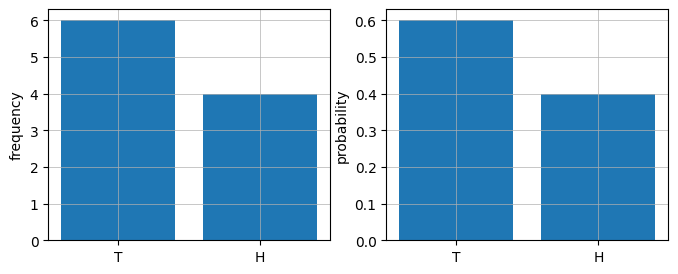

In [3]:
# primitive / raw way: just plot the bar graph
fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(1, 2, 1)
ax.bar([0, 1], [n_tails, n_heads])
ax.set_xticks([0, 1])
ax.set_xticklabels(["T", "H"])
ax.set_ylabel(r"frequency")
ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(1, 2, 2)
ax.bar([0, 1], [n_tails / n, n_heads / n])
ax.set_xticks([0, 1])
ax.set_xticklabels(["T", "H"])
ax.set_ylabel(r"probability")
ax.grid(lw=0.5, zorder=0)

There is the `plt.hist` and `np.histogram` function that can actually do this also, though technically you should really use that for **continuous data**. So the procedure below is formally invalid, although there is no practical consequence as such (I suppose this is ok because you know exactly why you are wrong and can defend the decision).

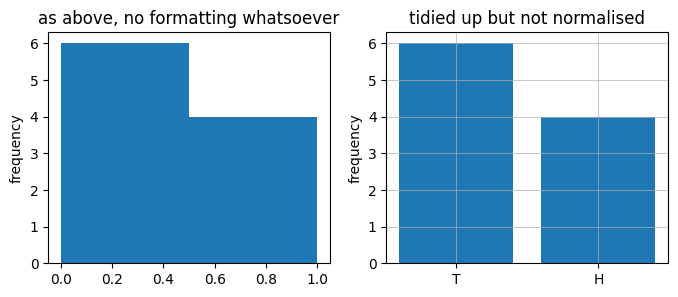

In [4]:
fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(1, 2, 1)
ax.hist(rolls, bins=[0.0, 0.5, 1.0]) # syntax reasons...
ax.set_ylabel(r"frequency")
ax.set_title(r"as above, no formatting whatsoever")

ax = plt.subplot(1, 2, 2)
ax.hist(rolls, bins=[0.0, 0.5, 1.0], rwidth=0.8)
ax.set_xticks([0.25, 0.75])
ax.set_ylabel(r"frequency")
ax.set_xticklabels(["T", "H"])
ax.set_title(r"tidied up but not normalised")
ax.grid(lw=0.5, zorder=0)


The thing with a computer is that we can do the coin toss experiment really quickly, so why not explore what happens with increasing sample size?

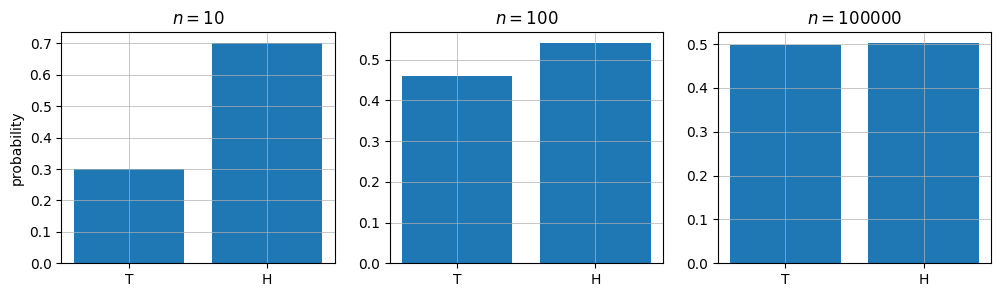

In [5]:
# dirty way of doing it quickly, should really do this in a subroutine
rolls_0010 = np.zeros(10, dtype=int)
rolls_0100 = np.zeros(100, dtype=int)
rolls_1000 = np.zeros(100000, dtype=int)  # because why not...

# force the random sequence to be starting from same point, so only difference here is size of n
np.random.seed(seed=167)
for i in range(10):
    rolls_0010[i] = heads_or_tails()
for i in range(100):
    rolls_0100[i] = heads_or_tails()
for i in range(100000):
    rolls_1000[i] = heads_or_tails()
  
  
fig = plt.figure(figsize=(12, 3))

n = 10
n_heads, n_tails = np.sum(rolls_0010 == 1), np.sum(rolls_0010 == 0)
ax = plt.subplot(1, 3, 1)
ax.bar([0, 1], [n_tails / n, n_heads / n])
ax.set_xticks([0, 1])
ax.set_xticklabels(["T", "H"])
ax.set_ylabel(r"probability")
ax.set_title(f"$n = {n}$")
ax.grid(lw=0.5, zorder=0)

n = 100
n_heads, n_tails = np.sum(rolls_0100 == 1), np.sum(rolls_0100 == 0)
ax = plt.subplot(1, 3, 2)
ax.bar([0, 1], [n_tails / n, n_heads / n])
ax.set_xticks([0, 1])
ax.set_xticklabels(["T", "H"])
ax.set_title(f"$n = {n}$")
ax.grid(lw=0.5, zorder=0)

n = 100000
n_heads, n_tails = np.sum(rolls_1000 == 1), np.sum(rolls_1000 == 0)
ax = plt.subplot(1, 3, 3)
ax.bar([0, 1], [n_tails / n, n_heads / n])
ax.set_xticks([0, 1])
ax.set_xticklabels(["T", "H"])
ax.set_title(f"$n = {n}$")
ax.grid(lw=0.5, zorder=0)

del rolls_1000   # clear this as it is hogging memory

So the thing we notice is that when $N$ is big (and it's huge here), the distribution of probability from experiments really starts looking like the expected values. This will be a common theme that will be utilised repeatedly in due course (it is because of the **law of large numbers**).

## Example: the fellowship of the sea-cucumber

Here is a moldy sea cucumber called Miffy, first of her name, warden of the couch, protector of Tower C, generator of stray fur.

<img src="https://i.imgur.com/c6ykARg.jpg" width="400" alt='cursed sea cucumber'>

Lets go with the weight of the sea cucumber above (because she keeps getting picked on for being fat). Lets suppose we take some amount of samples of her weight over some time period.

> NOTE: I cheated here and generated her weights using a **Gaussian/normally distributed** (see further on if you like) random number generator `np.random.randn` below, with some specified mean and s.t.d.; the point here is I want to have some numbers that are largely centered around the mean, with some fluctuations about it.

Having generated my weights, I plot the **histogram**. Unlike the bar graph, the histogram has continuous bars that are next to each other, with some **bin widths** that in this case depends on the number of **bins** I specify (uniform bin width by default, but there is the option to specify your own set of bins if you want). What you do here is you take the interval, chop it up into the whatever number or specification of bins, where the bins span some region (in this case weight). You then go through the sample, and for each data point see whether it is in the bin or not (e.g. a sample of 3.0 would like in the bin $2.95 < x \leq 3.05$, but not $ 2.85 < x \leq 2.95$), and if it is, add one to the frequency, and when it's done, plot it out.

> NOTE: Sometimes it is useful to use the `np.histogram` command to generate the bins and frequencies first, before you plot it out with `np.bar`, particularly if you want to have the frequency variable in the memory.

program decided bin sizes here are = [1.94512264 2.10985728 2.27459193 2.43932657 2.60406121 2.76879586
 2.9335305  3.09826514 3.26299979 3.42773443 3.59246907 3.75720372
 3.92193836 4.086673   4.25140765 4.41614229]


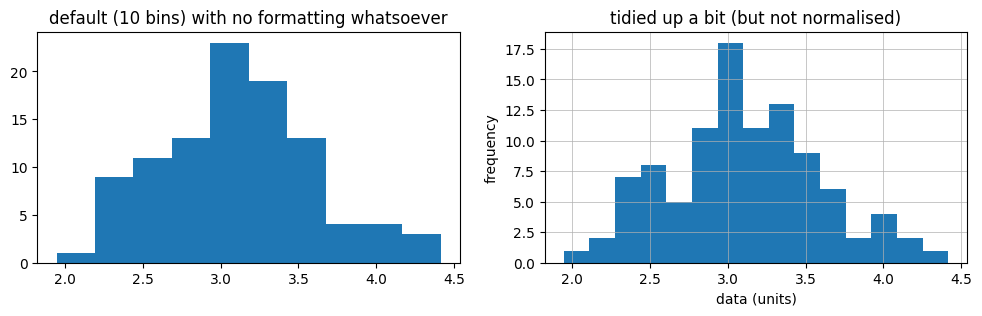

In [6]:
sample_size, mean, std = 100, 3.0, 0.5
data = mean + std * np.random.randn((sample_size))

# 1) notice the "n" here in randn, compared to just rand
# 2) randn by default gives normal distribution with mean = 0 and std = 1, above just shifts it

fig = plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 2, 1)
ax.hist(data)
ax.set_title(r"default (10 bins) with no formatting whatsoever")

ax = plt.subplot(1, 2, 2)
freq, bins, _ = ax.hist(data, bins=15)  # increase the number of bins
ax.set_ylabel(r"frequency")
ax.set_xlabel(r"data (units)")
ax.set_title(r"tidied up a bit (but not normalised)")
ax.grid(lw=0.5, zorder=0)

print(f"program decided bin sizes here are = {bins}")

## Probability distribution

The histogram and bar graphs are done to visualise the frequency of the data in some discrete form, and they are closely related to the **probability distribution function (pdf)**.

1) For the coin case, since the coin is constructed to be fair, we say we are drawing samples from the **uniform distribution**, where each outcome (from the RNGesus) is equally likely, or in symbols, we say $X\sim \mathcal{U}[\ldots]$, where $\ldots$ is the space of events to be specified.

2) For the sea cucumber case, we are drawing samples from the **normal distribution** or **Gaussian distribution** (the mean the same thing), where outcome (from the RNGesus) near the mean is more likely, with decreasing probability as we move away from the mean $\mu$, dictated by the value of the s.t.d. $\sigma$. In symbols, we say $X \sim \mathcal{N}(\mu, \sigma)$.

The two respective pdfs look like the following. 

> NOTE: For the Gaussian distribution, I have used the population mean and s.t.d $\mu$ and $\sigma$, assuming I actually know these.

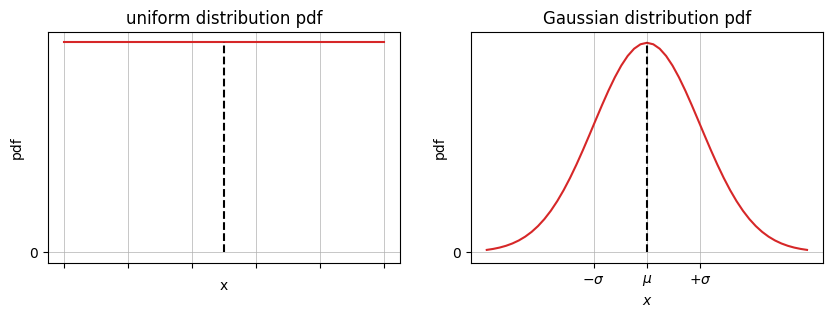

In [7]:
fig = plt.figure(figsize=(10, 3))

ax = plt.subplot(1, 2, 1)
ax.plot([0, 1], [1, 1], "C3")
ax.plot([0.5, 0.5], [0, 1], "k--")
ax.set_xticklabels([])
ax.set_yticks([0])
ax.set_xlabel(r"x")
ax.set_ylabel(r"pdf")
ax.set_title(r"uniform distribution pdf")
ax.grid(lw=0.5, zorder=0)

# normalised Gaussian pdf
x = np.linspace(-3, 3, 51)
pdf = ( 1 / np.sqrt(2.0 * np.pi) * np.exp(-0.5 * x**2 ) )

ax = plt.subplot(1, 2, 2)
ax.plot(x, pdf, "C3")
ax.plot([0, 0], [0, 0.4], "k--")
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels([r"$-\sigma$", r"$\mu$", r"$+\sigma$"])
ax.set_yticks([0])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"pdf")
ax.set_title(r"Gaussian distribution pdf")
ax.grid(lw=0.5, zorder=0)

For both of these I have deliberately not labelled the $y$-axis except for the zero line; mostly I wanted to demonstrate the shape of the pdf. For the uniform pdf, the distribution is, well, uniformly distributed over the outcomes. For the Gaussian pdf, this takes the well-known symmetric bell-curve shape, with events near the (population) $\mu$ most likely, and events away from the mean being increasingly unlikely, dictated by $\sigma$.

Pdfs have the property that they integrate to 1 over the whole list of possible events (related to how the probability for discrete outcomes like the dice should sum to 1). This is one reason why I didn't label anything on the pdf axis, because the value of the pdf depends on the possible events:

1) For the coin case on the left with uniform distribution, if for simplicity we just take the width to be 1 for each outcome, then we have

\begin{equation*}
    1\times p({\rm heads}) + 1\times p({\rm tails}) = 1, \qquad p({\rm heads}) = p({\rm tails}),
\end{equation*}

and the only answer is $p({\rm heads})=p({\rm tails})=1/2$, as expected. For $N$ possible outcomes following the uniform probability distribution, we would have $p=1/N$.

2) For the sea cucumber on the right with Gaussian distribution, the pdf depends on $\mu$ and $\sigma$ as

\begin{equation*}
    p(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \mathrm{exp}\left[-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2\right],
\end{equation*}

where $\mathrm{exp}[\cdots] = \mathrm{e}^{[\cdots]}$, THE exponential function. The domain here is taken to be over the real line, from minus to plus infinity.

> NOTE: Making use of the fact that the pdf should integrate to 1, the "fun" (?) observation then is that (after a quick substitution)
>
>\begin{equation*}
    \int_{-\infty}^{+\infty} \mathrm{e}^{-x^2}\; \mathrm{d}x = \sqrt{\pi}.
\end{equation*}
> This might be notable because we don't have $F(x)$ such that $F'(x) = \mathrm{e}^{-x^2}$, so the integral is not trivially done as a standard integration through the Fundamental Theorem of Calculus.

If I move $\mu$ around then I move the pdf left or right, and if I increase $\sigma$ I make the centre bit wider, and vice-versa, such that the total pdf integrates to 1.

So a theoretical banana skin here is that the probability is the ***integral*** of the pdf, and not the value of the pdf at some isolated location (which technically would be zero because there is no "area" under the pdf for just an isolated point). For the case of the discrete case there is an implicit assumption that the "width" of the event is one, but for continuous data it doesn't make sense to talk about the say $p(2.5)$ (because that is zero), and we should be talking about say $p(2.49 < x < 2.51)$.

The point here is that **if you know the pdf you know everything statistic about the data**. If you can somehow argue that your data, as represented by your histogram, is like some pdf (either by fitting or arguing), then *you have all the information you need* about your data in some sense.

> <span style="color:red">**Q.**</span> Suppose you have a *unfair* coin with bias toward rolling heads. Draw out on a piece of paper (or plot it if you want) what that would look like.

> <span style="color:red">**Q.**</span> If you are in the outer tails of the Gaussian pdf, what does this mean? This will be important for hypothesis testing later.

## Central Limit Theorem and Gaussian pdf

We make a distinction between **population parameters** $\mu$ and $\sigma^2$ and **sample parameters** $\overline{x}$ and $s^2$. The former is for the whole population (usually unknown), while the sample is taken from the population.

I am going to state things loosely and without mathematical proof, and just talk about the implications. The **law of large numbers** tells you that, if your sample size is big enough, then your sample mean and s.t.d. converge almost surely to the expected (i.e. population) mean and s.t.d., so from the sample statistics you can get at the population statistics (the latter you usually don't have access to). This is the reason for the observation for the fair coin above, and is also part of the reason that large samples are a good thing if you can get at it.

> NOTE: Law of large numbers also forms the basis of **Monte Carlo methods**; look these up or ask me if you are interested.

The **Central Limit Theorem** takes this even further: if you have large enough samples, under fairly general conditions you can approximate the data distribution *as if they were Gaussian*, even if the underlying distribution is not Gaussian. This is a very powerful statement, because remember if you have the pdf you have everything, and the CLT is telling you if you have large enough samples you can probably use the Gaussian pdf. THAT is one of the primary reasons why we really want want large samples, because if you have the pdf you have all the statistics of the data you care about.

> NOTE: In practice you don't need your sample size that large either, although you should always check, either by probing the data by plotting histograms and/or some statistical tests; see *06_statistical_test* for example.

The below code takes the sea cucumber weight and plots on top of it the theoretical Gaussian pdf, constructed from the sample mean and s.t.d. 

> <span style="color:red">**Q.**</span> Trying playing around with the sample size and convince yourself about CLT in action. You may want to increase the number of bins as you increase the sample size too.

integral of histogram = 0.9900000000000002
integral of pdf       = 0.9731065385766111


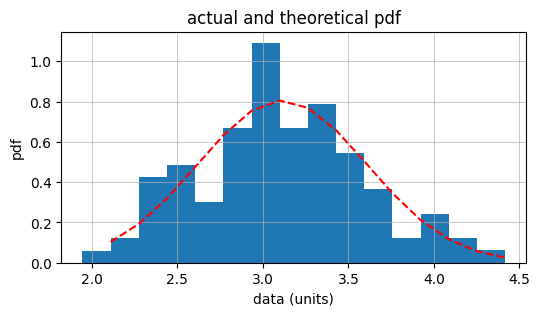

In [8]:
# sample_size, mean, std = 100, 3.0, 0.5
# data = mean + std * np.random.randn((sample_size))
data_mean, data_std = np.mean(data), np.std(data, ddof=1)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
weights, bins, _ = ax.hist(data, bins=15, density=True)  # density=True => resulting historgram integrates to 1
x_loc = bins[0:-1:] + np.diff(bins)
pdf = ( 1 / np.sqrt(2.0 * np.pi * data_std**2) 
      * np.exp(-0.5 * ((x_loc - data_mean) / data_std) ** 2 )
      )
ax.plot(x_loc, pdf, 'r--')
ax.set_ylabel(r"pdf")
ax.set_xlabel(r"data (units)")
ax.set_title(r"actual and theoretical pdf")
ax.grid(lw=0.5, zorder=0)

# check that the relevant things to end up integrating close to 1
# note: integrate to 1, not sum to 1 (they are not necessarily the same things)
print(f"integral of histogram = {np.trapz(weights, x_loc)}")
print(f"integral of pdf       = {np.trapz(pdf, x_loc)}")

## Gaussian pdf: Z-scores and confidence intervals (CIs)

Still need a few more things before we get to the hypothesis testing.

The **standard score** or sometimes the **Z-score** is when you take the data, remove the mean and scale by the s.t.d. (by either the population or the sample, depending on which you have), so that your result data now has zero mean and unit s.t.d. Or, in equations, taking the sample to be $x_i$, you consider instead

\begin{equation*}
    z_i = \frac{x_i - \mu}{\sigma}.
\end{equation*}

Assuming CLT applies, if we are essentially saying if $X\sim\mathcal{N}(\mu, \sigma)$, then we transform $X$ to $Z$ such that $Z\sim\mathcal{N}(0, 1)$. This is like *non-dimensionalisation* in physics, where you rescale and work in non-dimensional units. This allows for comparison for example: when you deal with actual variables you might care about the weight in $\mathrm{kg}$ or the height in $\mathrm{m}$ or the cursedness in units of insight (this is a [Bloodborne](https://www.playstation.com/en-gb/games/bloodborne/) reference), but these become comparable in a sense when you rescale them to have the same units (which, in this case, is no units).

Or, saying the same thing with an example, in some instances you might care about the actual units, but sometimes you only really care if you are above or below the mean (and by how much), such as your midterm/final scores. The general culture here is you want to know the mean and s.t.d. so you know roughly where you are in the class, rather than your raw mark, because some instructors scale the letter grades accordingly. I personally don't do re-scaling like this, but you could in some cases get 90% in a test and get a C because everybody did well, or 30% in a test and get a B+ because the test was next to impossible, so raw marks themselves might not be relevant, and the standardised score is more useful.

We can always do this standardisation, so we will base or discussion on the standardised case. Below is some code where we do this manually for the sea cucumber.

> NOTE: The `StandardScaler` from when we did PCA actually does this, so you have encountered this already.

integral of histogram = 0.99
integral of pdf       = 0.9799398529190075


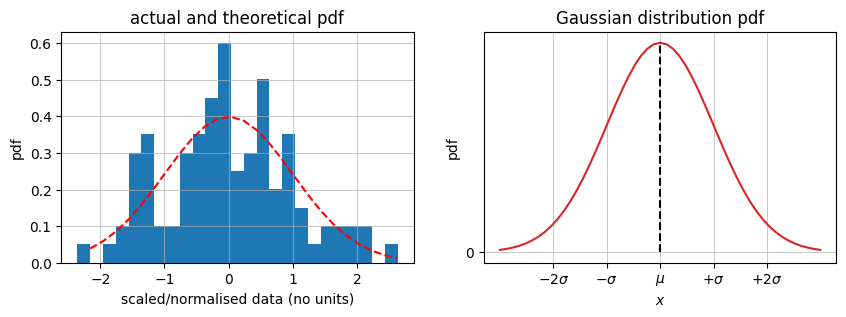

In [9]:
data_mean = np.mean(data) 
data_std  = np.std(data, ddof=1)  # note this is the one with (n-1) in the denominator

# scale it
data_scaled = (data - data_mean) / data_std

# do the same plot as above but with the pdf of N(0, 1)
freq, bins, _ = ax.hist(data_scaled, bins=25)  # increase the number of bins
x_loc = bins[0:-1:] + np.diff(bins)

fig = plt.figure(figsize=(10, 3))
ax = plt.subplot(1, 2, 1)
weights, bins, _ = ax.hist(data_scaled, bins=25, density=True)
pdf = ( 1 / np.sqrt(2.0 * np.pi) 
      * np.exp(-0.5 * x_loc ** 2 )
      )
ax.plot(x_loc, pdf, 'r--')
ax.set_ylabel(r"pdf")
ax.set_xlabel(r"scaled/normalised data (no units)")
ax.set_title(r"actual and theoretical pdf")
ax.grid(lw=0.5, zorder=0)

# check that the relevant things to end up integrating close to 1
# note: integrate to 1, not sum to 1 (they are not necessarily the same things)
print(f"integral of histogram = {np.trapz(weights, x_loc)}")
print(f"integral of pdf       = {np.trapz(pdf, x_loc)}")

# normalised Gaussian pdf
x = np.linspace(-3, 3, 51)
pdf = ( 1 / np.sqrt(2.0 * np.pi) * np.exp(-0.5 * x**2 ) )

ax = plt.subplot(1, 2, 2)
ax.plot(x, pdf, "C3")
ax.plot([0, 0], [0, 0.4], "k--")
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_xticklabels([r"$-2\sigma$", r"$-\sigma$", r"$\mu$", r"$+\sigma$", r"$+2\sigma$"])
ax.set_yticks([0])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"pdf")
ax.set_title(r"Gaussian distribution pdf")
ax.grid(lw=0.5, zorder=0)

The observation here is a lot of the data lies within $\pm 1\sigma$, while the majority of data lies between $\pm 2\sigma$. In fact, since we know the theoretical pdf, you can work out to a very high accuracy how much data lies within $\pm 1\sigma$ and so forth, via

\begin{equation*}
    p(-\sigma < z < \sigma) = \frac{1}{\sqrt{2\pi}}\int_{-\sigma}^{\sigma}  \mathrm{e}^{-z^2 / 2}\; \mathrm{d}z \approx 0.68
\end{equation*}

(which is $p(x)$ above but with $\mu=0$ and $\sigma=1$). This is the basis of the [**68-95-99.7 rule**](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule), where 68, 95 and 99.7% of the data lies within 1, 2 and 3 s.t.d. of the mean, assuming Gaussian distribution (so is applicable to a lot of cases with large enough samples through the CLT).

> <span style="color:red">**Q.**</span> The 68-95-99.7 rule for the theoretical Gaussian pdf is useful to remember but actually drops the decimal places. Verify numerically the rule and provide the actual answer accurate to two decimal places (Wikipedia has the answer for reference). This time you probably do have to use the `np.trapz` or analogous commands, and make sure you give it enough grid points, otherwise the integration is not that accurate.

> <span style="color:red">**Q.**</span> (slightly involved) The above discussion was for the theoretical pdf, but does it work as well for the experimental data? Try and verify the 68-95-99.7 rule through numerical experiments, using the sea cucumber data for example. 
>
> Essentially you want to integrate the histogram, which you can do by working out numerically the area represented by the histograms in some region, or you could also use the trapezium rule through `np.trapz` (look up syntax in manual or usage in code above, and be careful to give it the CENTRE locations of the bins, rather than the edges given directly by `np.histogram`). Explore how fast we converge to the 68-95-99.7 rule as sample size increases (we know it should happen by law of large numbers and CLT).

In the above, we were asking that, given the (in this case) the $z$ values, what is the associated probability? You can ask the converse question: given the probability, what is the associated interval? Mathematically, you are trying to find, for the some given $P$, the $\tilde{z}$ such that

\begin{equation*}
    p(-\tilde{z} < z < \tilde{z}) = \frac{1}{\sqrt{2\pi}}\int_{-\tilde{z}}^{\tilde{z}}  \mathrm{e}^{-z^2 / 2}\; \mathrm{d}z = P.
\end{equation*}

The **confidence interval (CI)** $(-\tilde{z}, \tilde{z})$ is precisely the answer to that question, which can again be computed here. For example, we already know where the **95% confidence interval** is for standard Gaussian distributed data, which is $(-2\sigma, 2\sigma)$.

> NOTE: Well technically it's like $(-1.96\sigma, 1.96\sigma)$, but who is counting...

In this case, `scipy.stats` has the commands built in to compute the confidence intervals (sometimes the quartiles), through in this case `stats.norm.interval`. Though the discussion is for standardised data, you can alway unravel it by restoring the scaling to give the confidence interval in "real" units, and `stats.norm.interval` actually does this for you if you provide the appropriate optional arguments (see below).

95% confidence interval for
default N(0, 1) data = (-1.9600, 1.9600)
scaled          data = (-1.9600, 1.9600)
unscaled        data = (2.1424, 4.0834)


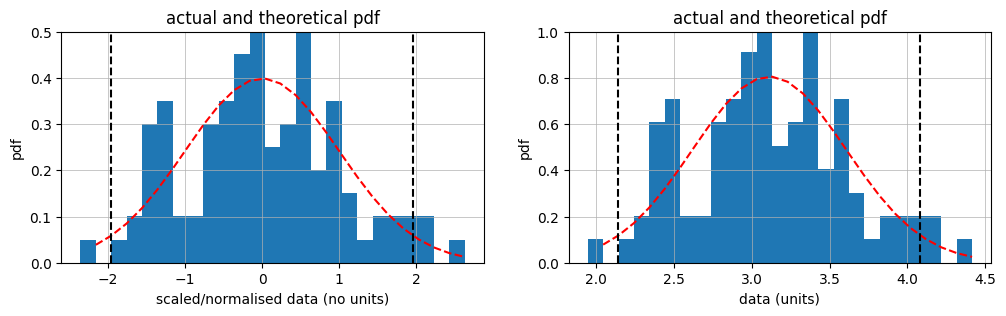

In [10]:
data_mean, data_std = np.mean(data), np.std(data, ddof=1)
data_mean_scaled, data_std_scaled = np.mean(data_scaled), np.std(data_scaled, ddof=1)

# for N(0, 1)
print(r"95% confidence interval for")
print(r"default N(0, 1) data = (%.4f, %.4f)" % stats.norm.interval(confidence=0.95))
# for the scaled data (which should be N(0, 1))
print(r"scaled          data = (%.4f, %.4f)" % 
      stats.norm.interval(confidence=0.95, loc=data_mean_scaled, scale=data_std_scaled))
# for unscaled data (gives the "un-scaled" confidence interval)
print(r"unscaled        data = (%.4f, %.4f)" % 
      stats.norm.interval(confidence=0.95, loc=data_mean, scale=data_std))

# define confidence intervals
scaled_CI = stats.norm.interval(confidence=0.95, loc=np.mean(data_scaled), scale=np.std(data_scaled, ddof=1))
data_CI = stats.norm.interval(confidence=0.95, loc=np.mean(data), scale=np.std(data, ddof=1))

fig = plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 2, 1)
weights, bins, _ = ax.hist(data_scaled, bins=25, density=True)
x_loc = bins[0:-1:] + np.diff(bins)
pdf = ( 1 / np.sqrt(2.0 * np.pi) 
      * np.exp(-0.5 * x_loc ** 2 )
      )
ax.plot(x_loc, pdf, 'r--')
ax.plot([scaled_CI[0], scaled_CI[0]], [0, 1], 'k--')
ax.plot([scaled_CI[1], scaled_CI[1]], [0, 1], 'k--')
ax.set_ylabel(r"pdf")
ax.set_xlabel(r"scaled/normalised data (no units)")
ax.set_title(r"actual and theoretical pdf")
ax.set_ylim(0, 0.5)
ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(1, 2, 2)
weights, bins, _ = ax.hist(data, bins=25, density=True)
x_loc = bins[0:-1:] + np.diff(bins)
pdf = ( 1 / np.sqrt(2.0 * np.pi * data_std**2) 
      * np.exp(-0.5 * ((x_loc - data_mean) / data_std) ** 2 )
      )
ax.plot(x_loc, pdf, 'r--')
ax.plot([data_CI[0], data_CI[0]], [0, 1], 'k--')
ax.plot([data_CI[1], data_CI[1]], [0, 1], 'k--')
ax.set_ylabel(r"pdf")
ax.set_xlabel(r"data (units)")
ax.set_title(r"actual and theoretical pdf")
ax.set_ylim(0, 1)
ax.grid(lw=0.5, zorder=0)

The definition I am using above for the confidence interval I think is not as strict as the formal definition, but will be ok for our purposes. There are various interpretations for the confidence interval, though putting these in words to me actually makes it more confusing...

One interpretation is that as a *limit*: if you were trying to get at the population parameter (say population mean), and do lots of repeated experiments/sampling to get a sample mean each with a confidence interval, the 95 confidence interval would be the interval where 95% of your *sample* confidence intervals would lie in as you take the sample size to infinity.

A bit mind bending isn't it? I certainly think so...

Below are what the 95% confidence intervals definitely are NOT (which is easier to state):

1) It is NOT the interval for which there is 95% probability that contains the population parameter (because once you throw down an interval, it either contains the population parameter, or it doesn't).

2) It does NOT mean 95% of the sample values are within the confidence interval (that's the quartiles; they are similar and related but not the same concepts).

3) It is NOT the definitive range of the sample parameter (the parameter could actually fall outside, but it is very unlikely).

4) As above, if you repeat an experiment/sampling, it does NOT mean there is a 95% probability that the sample parameter will be inside the interval.

---------------
# b) Hypothesis testing: formalism and the Z-test

(If you think the above is confusing, it's not really going to get better. I will try and at least highlight what are the WRONG interpretations...)

Lets start with an example. Below I generate the sea cucumber's weight before (through the Gaussian RNGesus), and I generate the sea cucumber's weight after change in diet/exercise/whatever (through the same RNGesus but modifying the parameters). I modify it three times, and the result I get is represented here by the histograms, where the blue is the control sample (you can just skip the code and run it, code below is for making the graphs to make the point.)

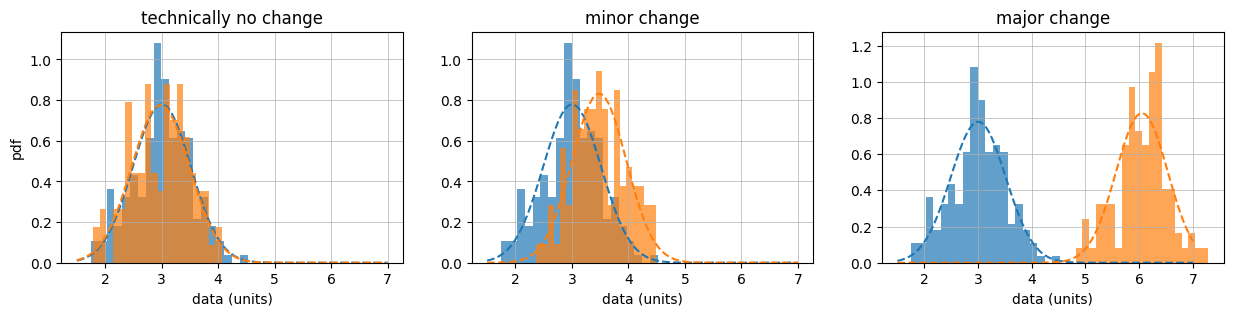

In [11]:
sample_size, mean, std = 200, 3.0, 0.5
data = mean + std * np.random.randn((sample_size))
data_mean, data_std = np.mean(data), np.std(data, ddof=1)

fig = plt.figure(figsize=(15, 3))
ax1 = plt.subplot(1, 3, 1)
weights, bins, _ = ax1.hist(data, bins=20, density=True, alpha=0.7, label="before")
x_loc = np.linspace(1.5, 7.0, 101)
pdf = ( 1 / np.sqrt(2.0 * np.pi * data_std**2) 
      * np.exp(-0.5 * ((x_loc - data_mean) / data_std) ** 2 )
      )
ax1.plot(x_loc, pdf, 'C0--')
ax1.set_ylabel(r"pdf")
ax1.set_xlabel(r"data (units)")
ax1.grid(lw=0.5, zorder=0)

ax2 = plt.subplot(1, 3, 2)
weights, bins, _ = ax2.hist(data, bins=20, density=True, alpha=0.7, label="before")
ax2.plot(x_loc, pdf, 'C0--')
ax2.set_xlabel(r"data (units)")
ax2.grid(lw=0.5, zorder=0)

ax3 = plt.subplot(1, 3, 3)
weights, bins, _ = ax3.hist(data, bins=20, density=True, alpha=0.7, label="before")
ax3.plot(x_loc, pdf, 'C0--')
ax3.set_xlabel(r"data (units)")
ax3.grid(lw=0.5, zorder=0)

# no change
sample_size, mean, std = 100, 3.0, 0.5
data = mean + std * np.random.randn((sample_size))
data_mean, data_std = np.mean(data), np.std(data, ddof=1)
_, _, _ = ax1.hist(data, bins=20, density=True, alpha=0.7, label="after")
pdf = ( 1 / np.sqrt(2.0 * np.pi * data_std**2) 
      * np.exp(-0.5 * ((x_loc - data_mean) / data_std) ** 2 )
      )
ax1.plot(x_loc, pdf, 'C1--')
ax1.set_title(r"technically no change")

# minor change
sample_size, mean, std = 100, 3.5, 0.5
data = mean + std * np.random.randn((sample_size))
data_mean, data_std = np.mean(data), np.std(data, ddof=1)
_, _, _ = ax2.hist(data, bins=20, density=True, alpha=0.7, label="after")
pdf = ( 1 / np.sqrt(2.0 * np.pi * data_std**2) 
      * np.exp(-0.5 * ((x_loc - data_mean) / data_std) ** 2 )
      )
ax2.plot(x_loc, pdf, 'C1--')
ax2.set_title(r"minor change")

# major change
sample_size, mean, std = 100, 6.0, 0.5
data = mean + std * np.random.randn((sample_size))
data_mean, data_std = np.mean(data), np.std(data, ddof=1)
_, _, _ = ax3.hist(data, bins=20, density=True, alpha=0.7, label="after")
pdf = ( 1 / np.sqrt(2.0 * np.pi * data_std**2) 
      * np.exp(-0.5 * ((x_loc - data_mean) / data_std) ** 2 )
      )
ax3.plot(x_loc, pdf, 'C1--')
ax3.set_title(r"major change")

So in this case we know the answer: 1st is cooked up to have no change (though the RNGesus effects will be present), and there are changes for 2nd and 3rd. While it is obvious in the 3rd case that there is a change, how might we algorithmically objectively call the 2nd and 1st case (and really the 3rd case too)?

## Hypothesis testing

Advance warning, this bit is going to be rough, and it is probably worth going through this a few times. I am not sure what is the best way of doing this, but here I am going to sketch out the logic by a process of reverse engineering, go through the formalism, apply it to an example using what would be the **Z-test**, then spend most of the time highlighting the many banana skins lying around.

The question here we want to ask is (say) ***does the diet/exercise/whatever have an impact on the sea cucumber mean weight?*** We can set up our experiments, and assuming these are appropriate controlled, compute means from different samples and find that they are different. But that by itself doesn't necessarily mean that much, because those sample means presumably come with a confidence interval, and they could be overlapping quite a bit, which means you could just be getting a difference by chance. However, to conclude solely based on non-overlapping confidence intervals is quite a strict condition (and it's not really the right thing to do anyway; you actually want the confidence intervals to compare the sample means, and if it doesn't include zero then you are good).

We won't be talking about confidence intervals that much here, even though I think those are actually better things to use (because the things below are more classical and widely used...) We are going to be focusing on **hypothesis testing**, which still relying somewhat on confidence intervals, but in a slightly different way. The idea here is we make some samples/experiments/observations, and ***given/assuming some hypothesis, how likely are we to actually get the sample statistics we just got?*** 

> NOTE: The ordering is important and revisited later: "given assumption" PRECEDES the "likelihood" clause.

The idea here is if the probability is low, then either:

1) You have a very surprising result, or

2) The original hypothesis was "wrong" and should be rejected, to be replaced by its converse or the alternative.

So the logic here is kind of (!!!) like "proof by contradiction" in mathematical proofs: you assume the *reverse* to what you want to proof, follow to where that takes you logically without making illegal moves, come to an absurd/contradictory conclusion, and the possibilities are either you screwed up as you went along, or the initial assumption was wrong. For argument sake lets say you really didn't make illegal moves, then you must conclude your initial assumption was wrong, so you should have what you wanted to show in the first place anyway.

If you are confused, I would recommend reading these a few times, because this thinking obstacle is quite important to circumvent, and to me forms the basis of a lot of the possible misinterpretations/abuses/confusions about hypothesis testing.

With that thought obstacle navigated, lets go to the formalism and then see how that works in an example. 

> NOTE: I think the next bit is actually fairly easy. The hard bit really is the reverse logic of sorts we are trying to use here, and points 1 and 5 below.

## Recipe for hypothesis testing

Formally what you do is to follow the recipe below:

1) Pose a **null hypothesis** (usually denoted $H_0$), which is the converse to what you are trying to show. You probably want an **alternative hypothesis** (usually denoted $H_1$), which is the converse to the null. ***Remember the aim here is to try and REJECT the null hypothesis***.

2) Decide on the statistical test based on the null hypothesis, data, sample size, distribution etc.

3) Set the threshold or **confidence level**, which is related to the confidence interval.

4) Compute the test statistic and/or the **$p$ value**, and see how it compares with the confidence level set just now.

5a) If the test statistic is larger than the threshold associated with the confidence level (or the $p$-value is less than the confidence level), then you are to **REJECT** the null hypothesis, and claim statistical significance of the converse. (However, see **statistical significance** vs. **practical significance** later.)

5b) If not, you **FAIL TO REJECT** the null hypothesis, and basically you can't really say anything (***THIS POINT IS IMPORTANT***: failing to reject the null hypothesis does NOT mean the null hypothesis is correct necessarily, or that there is no significance). Either you go back and re-design your experiment, gather more data and try again, or try something else (or you could give up too I guess).

## Example: The two sea-cucumbers, and the Z-test

**Z-test** is used when you have ample amount of data, you know the population variance $\sigma^2$ or have a good estimate for it, and your data follows a Gaussian distribution (which might be ok when sample size is large because of CLT). This is the case we have here for the sea cucumber example, or we can certainly force that condition to be satisfied; we will talk about other tests available when some of these conditions are not satisfied. 

The Z-test statistic is given by

\begin{equation*}
    Z = \frac{\overline{x} - \mu}{\sigma/\sqrt{N}},
\end{equation*}

which is basically the Z-score with a $1/\sqrt{N}$ scaling. Note that here we are using the population s.t.d.; if we don't know that, we can probably use the sample s.t.d. $s$ instead if the samples are large enough.

The question we want to try and claim is that **the diet/exercise/whatever does affect the mean weight**. There are two ways we could do this, either compare this with the population mean (the **one sample Z-test**), or compare this between samples (the **two sample Z-test**). The first one is easier so we are going to do that first.

So, following the recipe above:

#### 1) Formulate the null and alternative hypothesis

The null is **the diet/exercise/whatever has NO effect on the mean weight**, or as formulated below, **the mean weight is $\mu = 3.00$**. The alternative is that there is an effect, or, as formulated below, **the sample mean weight is NOT $\overline{x} = 3.00$**.

#### 2) Decide on the test

As advertised, we are in the large-ish data regime with Gaussian distribution, so we are going to use the Z-test. Here we want the **two-sided Z-test** because of the alternative hypothesis: we want to know whether there are differences, and not care about the sign of the difference as such. This affects point 4 when we set up the calculation.

#### 3) Set the confidence value

This is sometimes denoted $\alpha$, and it is convention to set this to be $0.1$, $0.05$ or $0.01$. Viewed from the point of view of the pdf, these are the probability values represented by the **tails of the pdf**, so $1-\alpha$ tells you the confidence intervals, and the $\alpha$ values above correspond to the 90%, 95% and 99% confidence interval. We are going to choose $\alpha=0.05$, but ***THIS IS A CONVENTION*** (more on this later).

#### 4) Do the test

This is the code below.

#### 5) Conclusion

This is also nested in the code below.

In [12]:
pop_mean = 3.0
alpha = 0.05    # so 95% significance

# generate some sea cucumber weights
# original: seed = 167, 100, 3.0, 0.5
np.random.seed(167)
sample_size, mean, std = 100, 3.5, 0.5
data = mean + std * np.random.randn((sample_size))

# compute the edges of the CI based on alpha
# unforunately "alpha" here is 1 - 0.05, notation clash
CI_vals = stats.norm.interval(confidence=1-alpha)

# compute the one sample Z-statistic

Z = (np.mean(data) - pop_mean) / (std / np.sqrt(sample_size))

print("=================")
print("Z-test evaluation")
print("=================")
print(f"edges of the {(1-alpha)*100}% CI edges = +-{CI_vals[1]:.4f}")
print(f"computed Z-statistic = {Z:.4f}")
print()
count = 0
if abs(Z) > CI_vals[1]:
    print(f"Z-statistic outside of quartile range, REJECT null hypothesis")
    print()
    print(f"   sample mean {np.mean(data):.4f} is significantly different to population mean {pop_mean:.4f}")
else:
    print(f"Z-statistic inside of quartile range, FAIL TO REJECT null hypothesis")
    print()
    print(f"   sample mean {np.mean(data):.4f} not significantly different to population mean {pop_mean:.4f}")

Z-test evaluation
edges of the 95.0% CI edges = +-1.9600
computed Z-statistic = 9.7466

Z-statistic outside of quartile range, REJECT null hypothesis

   sample mean 3.4873 is significantly different to population mean 3.0000


The example above only deals with one sample, but we could basically do the same comparison between a control group and a test group. The main difference here is we are going to be doing the **two-sample Z-test**, which requires us to compute instead

\begin{equation*}
    Z = \frac{(\overline{x}_1 - \overline{x}_2) - (\mu_1 - \mu_2)}{\sigma_1/\sqrt{N_1} + \sigma_2/\sqrt{N_2}},
\end{equation*}

where the subscript denotes the population of the two groups. The null hypothesis here is that there is no change in the means, so $\mu_1 = \mu_2$, and we are going to see if the sample data can reject that.

In [13]:
alpha = 0.05    # so 95% significance

# generate some sea cucumber weights
# original: seed = 167, 100, 3.0, 0.5
np.random.seed(167)
sample_size, mean, std = 100, 3.0, 0.5
control_data = mean + std * np.random.randn((sample_size))

sample_size, mean, std = 100, 3.5, 0.5
test_data = mean + std * np.random.randn((sample_size))

# compute the edges of the CI based on alpha
# unforunately "alpha" here is 1 - 0.05, notation clash
CI_vals = stats.norm.interval(confidence=1-alpha)

# compute the two sample Z-statistic

Z = (np.mean(test_data) - np.mean(control_data)) / (std / np.sqrt(sample_size) + std / np.sqrt(sample_size))

print("=================")
print("Z-test evaluation")
print("=================")
print(f"edges of the {(1-alpha)*100}% CI edges = +-{CI_vals[1]:.4f}")
print(f"computed Z-statistic = {Z:.4f}")
print()
count = 0
if abs(Z) > CI_vals[1]:
    print(f"Z-statistic outside of quartile range, REJECT null hypothesis")
    print()
    print(f"""  test group mean {np.mean(test_data):.4f} is significantly different to \
control mean {np.mean(control_data):.4f}""")
else:
    print(f"Z-statistic inside of quartile range, FAIL TO REJECT null hypothesis")
    print()
    print(f"""  test group mean {np.mean(test_data):.4f} not significantly different to \
control mean {np.mean(control_data):.4f}""")

Z-test evaluation
edges of the 95.0% CI edges = +-1.9600
computed Z-statistic = 5.0225

Z-statistic outside of quartile range, REJECT null hypothesis

  test group mean 3.4896 is significantly different to control mean 2.9873


> <span style="color:red">**Q.**</span> (theoretical) Why do I only care about one of the CI edges in the two-tailed case?

> <span style="color:red">**Q.**</span> (some care required) Here we only compute the test statistics, but try and compute the associated $p$-value as well (look up the syntax for this; you can get this from `stats.norm.cdf` or `stats.norm.sf` if need be, but a bit of thinking is required to throw in the right numbers).

> <span style="color:red">**Q.**</span> Try messing around with the confidence values, mean and s.t.d. used to generate the samples. Particularly if you make the differences in the means too small, what happens?

> <span style="color:red">**Q.**</span> Try and see if you make the differences in the mean not too big and small, and find a case where you sometimes reject the null hypothesis, and sometimes when you fail to reject (play around with the seed for example).

> <span style="color:red">**Q.**</span> Try taking the sample size to be small to the point where we might expect to start violating the assumptions of the Z-test, just to see what could go wrong (learning how things go wrong is also important, and in my opinion more useful than doing things right all the time).

--------------
# c) Some banana skins and things to be aware of

(This bit really is just text, with one quite involved coding example.)

I hope you will agree that the actual calculation part is actually not too bad, and there really is a set algorithm for doing hypothesis testing. The bits to be careful about is really in the interpretation, and here are a few.

## Null hypothesis

This bit relates to procedure 1 and 5. ***You never "proof" the null hypothesis, you only ever try and reject it***. The null hypothesis is the working assumption you make do with until something better comes along. So you never ACCEPT the null hypothesis, merely that you FAIL TO REJECT the null hypothesis.

To make the proof by contradiction analogy, it is one of those necessary but not sufficient conditions. Assuming all moves are logically legal, finding a contradiction means your assumption should be wrong. But if you don't find a contradiction, it could mean the assumption is actually wrong, but it could also be you are just not looking hard enough, so you can't say anything as such. The same is true in hypothesis testing. If you reject the null hypothesis, good for you (but check for errors, see below). On the other hand, if you fail to reject it you can't say anything, because it could be that your data is not co-operating, or that the data really is telling you there is no reason to reject it.

## Statistical significance + practical significance

***Just because you reject or fail to reject the null hypothesis because of statistical (in)significance, it doesn't mean the null hypothesis is true or false***. One reason relates to the above point: it is just a hypothesis. Another reason is that you could just be wrong: you could be rejecting the null hypothesis when it is actually true, or failing to reject the null hypothesis when it is false. These are related to the **Type I** and **Type II** errors later. 

Statistical significance is just that, statistical significance, nothing more and nothing less. Just because something does not pass the statistical test doesn't mean it is false.

***Just because something is statistically significant does not mean it is of practical significance***. The problem with the null and alternative hypothesis is that it is fairly broad and general. Yes your means might be different, but if the actual difference is only 10 grams say, you have to decide whether 10 grams is important or not. In this sense confidence intervals are much better, because it give you uncertainty ranges from which you can access whether things are of practical significance.

## $p$-values and significance/confidence level

Where to even start with this one...

We haven't had to use the **$p$-values** here, though we can actually compute these for the examples above, and we will use these more in the *06_statistical_tests*. What you will find is that the associated $p$-values for the above two original examples are really small (because the test statistic is quite a bit bigger than the confidence interval edges), and the calculated $p$-values are much smaller than the threshold $\alpha = 0.05$. 

First point is that ***the $p$ value is not the probability that the null hypothesis is true***, as is commonly interpreted. This relates to the ordering of the phrase ***given/assuming some hypothesis, how likely are we to actually get what we just got***. The $p$ value IS "the probability of observation GIVEN hypothesis", and NOT "the probability of hypothesis GIVEN observation"; in symbols, the $p$-value is the *conditional probability* $p(x|H_0)$ and NOT $p(H_0|x)$. You don't attribute probabilities to a hypothesis (certainly not in the frequentist view): the hypothesis is either correct, or it is not, you can't be correct with probability $p$. A similar point holds for being able to reject the null with the 95% confidence: it doesn't mean there is a 95% chance that the null is false. The media for example generally does not distinguish this important subtlety, which perpetuates the confusion...

Second point is that ***the $p$-value is not the likelihood of the observation is purely due to chance***. Again, it is the observation GIVEN the hypothesis, which is not the same thing.

Third point is that ***the $p$-value being small does not measure significance or importance of observation***. There are cases I could artificially increase my sample size and make the $p$-value as small as I like. For example, in the Z-statistic scales like $\sqrt{N}$, so by increasing $N$ I can make the Z-statistic really big, with corresponding tiny $p$ values. That doesn't mean my result is more significant necessarily.

## Type I errors: false positives

On that note, ***the $\alpha=0.05$ confidence is purely by convention!*** The value appeared to have came from Ronald Fisher, who was mostly dealing with relatively small samples. Somehow this observation about small samples has been ignored and the default for a while is $\alpha=0.05$ particularly in clinical, social and life sciences, regardless of whether it is suitable or not. For large samples and cases where multiple testing is involved, a more stringent threshold should be used; particle physics normally use the $5\sigma$ significance level, which is roughly $\alpha = 0.0000003$ (or 1 in 3.5 million).

The $\alpha$ value in this case is essentially the **Type I** error, where you **incorrectly reject the null hypothesis when the null is actually true**, or reporting a **false-positive**. 

The practical problem associated with the is that the confidence thresholds are treated as the "stop" conditions: once the test reports statistical significance, stop and report, and that's it (that is actually bad practice). The two issues that have been repeatedly highlighted are:

1) Given I can hypothetically make my $p$-values as small as like with increasing sample size, I can always try and fudge it so that I can always get a result such that my $p$-value is smaller than some $\alpha$ I choose, allowing me to reject my null hypothesis when I feel like it.

2) I could repeatedly probe my set of data, throwing out what I might regard as outliers, grouping them accordingly, changing tests, season them with salt and pepper, whatever, and repeat my tests. I am essentially doing **multiple testing** and artificially increasing sampling rate for the same fixed $\alpha$, and conclude somewhere that I have a statistically significant result, stop and report.

This problematic (but not unheard of approach) results in a ton of false-positives lying around, and a lot of the experimental "discoveries" are not really discoveries, it's just sampling noise. This is a counter-intuitive fact of probability that we don't often grasp, that **unlikely events almost surely occur given large enough samples**. A perfect example of this would be the lottery: the probability of winning is so small, but if enough people play, then someone will surely win. If you sample and test enough times, you are likely to get a hit eventually, and usually only that hit gets reported.

> NOTE: This has been noted to be a big problem particularly in the clinical, social and life sciences. There is publication bias to only report things that are below the $\alpha=0.05$ threshold. Given a 5% false-positive rate, for every 1000 papers reporting a "discovery", you might expect there are 50 that are not really significant. 
>
> It is actually much worse than that; see exercise later. It's no joke that there has been reports of a reproducibility crisis particularly in the clinical, social and life sciences going on (see e.g. [this article](https://www.nature.com/articles/533452a)).

## Example: the return of the sea-cucumber

Below are two examples I cooked up where I can readily reject the null hypothesis even though it should not be rejected since it is true, still using the sea cucumber data. The first one I repeatedly generate the data, so I am increasing the sample size by increasing the number of my experiments. The second is that I take the fix set of data but randomly subset them, and pass them through the test, which is also increasing the sample size. 

I am essentially torturing the data until it confesses. I am able to consistently find false-positives that I can report on and write my Nobel prize paper with, and artificially enlarge my publication count.

In [14]:
# repeatedly generate data

np.random.seed(1)

def Z_test_repeat(n=100, alpha=0.05):
    
    pop_mean = 3.0
    CI_vals = stats.norm.interval(confidence=1-alpha)

    for i in range(n):
        # generate some sea cucumber weights
        sample_size, mean, std = 100, 3.00, 0.5
        data = mean + std * np.random.randn((sample_size))
        Z = (np.mean(data) - pop_mean) / (std / np.sqrt(sample_size))

        if abs(Z) > CI_vals[1]:
            print(f"null hypothesis can be rejected at run {i}, yay, going to stop and write a paper")
            print(f"(but of course this is a false-positive, because I forced my samples to have the same mean)")
            return
    
    print(f"no false-positive found, good? (try turning $n$ up)")

Z_test_repeat()

null hypothesis can be rejected at run 30, yay, going to stop and write a paper
(but of course this is a false-positive, because I forced my samples to have the same mean)


In [15]:
# repeatedly subset

import random

np.random.seed(1)
random.seed(1)    # reproducibility for the random shuffle of the list

def Z_test_shuffle(n=100, subset=50, alpha=0.05):
    
    pop_mean = 3.0
    CI_vals = stats.norm.interval(confidence=1-alpha)
    
    sample_size, mean, std = 100, 3.00, 0.5
    data = mean + std * np.random.randn((sample_size))

    for i in range(n):
        # generate some sea cucumber weights
        dummy = random.sample(list(data), subset)  # syntax
        Z = (np.mean(dummy) - pop_mean) / (std / np.sqrt(len(dummy)))

        if abs(Z) > CI_vals[1]:
            print(f"null hypothesis can be rejected at run {i}, yay, going to stop and write a paper")
            print(f"(but of course this is a false-positive, because I forced my samples to have the same mean)")
            return
    
    print(f"no false-positive found, good? (try turning n up)")
    
Z_test_shuffle()

null hypothesis can be rejected at run 44, yay, going to stop and write a paper
(but of course this is a false-positive, because I forced my samples to have the same mean)


Here I am being deliberately malicious to make a point, but what is to say this doesn't happen, either by design, not by design but unwittingly because of not being aware of these issues, or simply by chance? Again, **unlikely events happen almost certainly given large samples**!

A fix of this effect is called the **Bonferroni correction**, where you scale the imposed $p$-value with the number of tests you are running (so in the case above, I should be using $\alpha = 0.05 / 100 = 0.0005$).

> <span style="color:red">**Q.**</span> Try manually modifying the calls to the subroutines, or better yet, make a copy of the subroutine and modify it so that it takes the Bonferroni correction into account.

## Type II error: false negatives

This is more to do with experimental set up, but included here for completeness. The **Type II errors** or **false-negatives**, commonly denoted $\beta$. This is the case where you **incorrectly fail to reject the null hypothesis, when the null hypothesis is false**.

This is harder to quantify because this really is to do with the design of the statistical experiment. It could be that the experiment designed does not have enough **statistical power** to distinguish effects, so that we are not able to reject the null hypothesis when we should. An example is the non-overlapping confidence interval test: we would reject the null if the confidence interval does not overlap, but that is quite a strict condition, and thus the procedure would be **under-powered** (but, again, that's not really what you should be doing anyway with confidence interval tests).

A statistical experiment's power is given by $1-\beta$, and a high power means $\beta$ is low, which is a good thing. The power depends on the choice of $\alpha$. The image below (taken from Wikipedia) gives a schematic of what we have been talking about (the "critical value" is related to the location corresponding to the choice of $\alpha$).

<img src="https://upload.wikimedia.org/wikipedia/commons/4/44/Statistical_test%2C_significance_level%2C_power.png" width="400" alt='pdf overlaps'>

One way to increase power is through the sample size (but be a bit careful of the choice of $\alpha$ value then). The way you do this is by specifying the **margin of error** you are willing to accept, and then compute

\begin{equation*}
    \hat{N} = \left(\frac{Z \sigma}{\rm margin\ of\ error}\right)^2,
\end{equation*}

where $\hat{N}$ is the suggested sample size, and $Z$ is the standardised Z-score associated with the confidence value $\alpha$ you choose (so $\hat{N}$ is $\alpha$ dependent). A problem here is you don't really know $\sigma$, because you haven't done sampling yet, so you'll have to make an intelligent guess or some exploratory experiments.

## Example: the sea-cucumber-lion

(I am clutching at straws here with the LOTR references here, but I do have a non-cursed picture.)

<img src="https://i.imgur.com/L8tL0rP.jpg" width="400" alt='cursed mirror image'>

Suppose you want to measure the mean weight of the now evolved sea-cucumber-lion, and you think it is around $3.00$ in whatever units, but you are willing to accept an error margin of say $0.25$ (so $3.00 \pm 0.25$ range), at the 95% confidence interval. We don't know the s.t.d. of the population, but lets say it is between 0.3 and 0.5.

The code below first computes the Z-score associated with the 95% confidence interval, and then plug in the numbers accordingly to give the implied sample size we should probably choose.

In [16]:
CI_vals = stats.norm.interval(confidence=0.95) # 95% confidence interval, get the edges of quartiles as Z score

print("===============================================")
print("computing suggested sample size (single sample)")
print("===============================================")
print(f"suggested value of sample_size > {int((CI_vals[1] * 0.5 / 0.25) ** 2)} here")

computing suggested sample size (single sample)
suggested value of sample_size > 15 here


> <span style="color:red">**Q.**</span> Why should we use the larger s.t.d. value of 0.5 instead of 0.3 here?

If we want to design a test to estimate the difference in means, then we put a factor of 2 in the calculation above but use the individual groups' s.t.d. for computing the sample size. This might not be known, so one might again need to do a guestimate, or accept this shortfall and use the same s.t.d. for both.

Suppose there is a control set of sea-cucumbers-lions with the above statistics, and you want to know whether another set of sea-cucumbers-lions exposed to a new diet/exercise/whatever affects the mean. If you want the margin of error to be no more than 0.25, then do the following (assuming both groups have the same s.t.d. here).

In [17]:
print("===============================================")
print("computing suggested sample size (two samples)")
print("===============================================")
print(f"suggested value of sample_size > {2 * int((CI_vals[1] * 0.5 / 0.25) ** 2)} in EACH group")

computing suggested sample size (two samples)
suggested value of sample_size > 30 in EACH group


> <span style="color:red">**Q.**</span> Without doing the calculation, what do you expect to happen if I ask for a higher confidence value (so a lower $\alpha$)? Once you know what you might expect, actually do the calculation.

> <span style="color:red">**Q.**</span> (more involved) For the above statistics of sea cucumber, plot the suggested sample size against the chosen confidence value.

To control the Type II error, we compute

\begin{equation*}
    \hat{N} = \left(\frac{Z_\alpha + Z_\beta}{\rm effect\ size}\right)^2, \qquad {\rm effect\ size} = \frac{|\mu_{\rm after} - \mu_{\rm before}|}{\sigma},
\end{equation*}

where $Z_\alpha$ is the Z-score associated with the choice of confidence value $\alpha$ and $Z_\beta$ is the Z-score associated with the choice of power, with the same comment as above about the s.t.d.

So how big do I want my sample size to distinguish a change in the mean from some population mean of 0.25, with $\sigma=0.5$ as above, at the 95% confidence level, with 80% power? We have $Z_\alpha = Z_{0.975}$ (because 5% in the two tails at 95% confidence interval) which we computed already. For $Z_\beta$, we have $\beta=0.2$ and want $Z_{0.8}$ (because 20% in one tail at 80% power). The code below does this.

In [18]:
quartile_vals = stats.norm.interval(confidence=0.95)
Z1 = quartile_vals[1]

quartile_vals = stats.norm.interval(confidence=0.60)
Z2 = quartile_vals[1]

effect_size = 0.25 / 0.5
print("===========================================================")
print("computing suggested sample size (controlling Type II error)")
print("===========================================================")
print(f"suggested value of sample_size > {int((Z1 + Z2) / effect_size) ** 2} to detect change of {effect_size}")

computing suggested sample size (controlling Type II error)
suggested value of sample_size > 25 to detect change of 0.5


If you have two samples and you want to see how the means are different, you do as above but need an extra factor of two, and the suggested sample size is for *each* group.

> <span style="color:red">**Q.**</span> Why are we using `alpha=0.60` to get $Z_{0.8}$ for the choice of 80% power? (hint: one was chosen for two tails while the other is one tail)

> <span style="color:red">**Q.**</span> Before you compute, what do you expect to happen to suggested sample size if you decrease effect size?

> <span style="color:red">**Q.**</span> (more involved) For the above statistics, plot the suggested sample size against the effect size for multiple choice of power. (Try 90% power for example, but being careful with changing the `alpha=0.60` bit; your $Z_\beta$ should have a raw value of around 1.282.

> <span style="color:red">**Q.**</span> (more involved) Suppose you go back to one of the Z-test examples above with the sample size of 100. Reverse engineer the calculation and calculate the power associated with the sample size of 100. (Calculate $Z_\beta$ and back out the value of $\beta$ out from that.)

------------

# Ending words

This notebook has been more words and concepts, and less on the code. There is quite a lot to take in, but it is important to do this slowly but do the procedure and interpretation correctly (they say **practise makes perfect** but, really, **_perfect_ practise makes perfect**). 

There is a cheat sheet with some of the summary in the next notebook, so here are some of the extended exercises with this notebook, as well as a random cursed image (one of the worst in my correction) to close this cursed notebook...

<img src="https://i.imgur.com/G7xJJvu.jpg" width="400" alt='cursed mirror image'>

----------------
# More involved exercises with this notebook

## 1) On statistical understanding: green jelly beans

Below is a comic from [XKCD](https://imgs.xkcd.com/comics/significant.png) highlighting some of the points about hypothesis testing I have made here. See if you can pick them out (I found at least four).

<img src="https://imgs.xkcd.com/comics/significant.png" width="500" alt='green jelly beans'>

# 2) On statistical understanding: false discoveries

This you can do by hand and requires drawing a decision tree of sorts, and is taken from David Spiegelhalter's book ["The Art of Statistics"](https://www.goodreads.com/book/show/43722897-the-art-of-statistics). Suppose 1000 hypothesis are made, with confidence level of 95% and power of 80% (so $\alpha=0.05$ and $\beta=0.20$). Suppose also that only 10% of the null hypothesis are actually false. Draw a decision tree with frequencies, where the first level is whether the null hypothesis is actually true or not (the 10% applies here), and the next level with the result of the significance testing (the $\alpha$ and $\beta$ apply here). From this, conclude that the above choice of parameters result in 125 reported discoveries, of which 45 of these are false-positives, i.e. 36% of the reported discoveries are dud discoveries, rather than the 5% you might expect from $\alpha=0.05$ (that's what I mean above when I say it's actually worse).

Explore what happens if you modify $\alpha$ and $\beta$, particularly when you *decrease* it (say $\alpha=0.01$ by itself, $\beta=0.1$ by itself, and some combinations thereof, or a more stringent criterion). Make a plot of the percentage of the false-discovery percentage say with varying $\alpha$ and $\beta$ if you want to practice your Python skills.

<img src="https://i.imgur.com/5Ll2eb2.jpg" width="400" alt='cat decision tree'>


## 3) penguins

Make some hypothesis up and do some of the exercises with the penguin data you have access to (see also next notebook).

In [19]:
import pandas as pd

option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

print("===============================")
print("sample of data")
print("===============================")
print(df.sample(10))
print()
print("===============================")
print("some basic statistics from data")
print("===============================")
print(df.describe())

loading data remotely
sample of data
     Culmen Length (mm)  Culmen Depth (mm)    Species
244                49.5               16.1     Gentoo
132                37.5               18.5     Adelie
278                52.7               19.8  Chinstrap
133                38.1               17.6     Adelie
22                 38.2               18.1     Adelie
203                45.1               14.4     Gentoo
74                 42.8               18.5     Adelie
119                36.2               17.2     Adelie
260                48.1               15.1     Gentoo
328                42.5               17.3  Chinstrap

some basic statistics from data
       Culmen Length (mm)  Culmen Depth (mm)
count          342.000000         342.000000
mean            43.921930          17.151170
std              5.459584           1.974793
min             32.100000          13.100000
25%             39.225000          15.600000
50%             44.450000          17.300000
75%             48.50

## 4) Type I and II errors

Cook up a some code as I did above to numerically explore the percentage of Type I and II errors for the sea cucumber example say (because you can run this many times; but you could use the iris or penguin data and do multiple testing too). For Type I, you would set the means to be the same, and count the times you reject the null hypothesis and report the percentage. For Type II, you would set the means to be different, and count the time you fail to reject the null hypothesis and report the percentage. Explore how this varies with sample size, s.t.d., degree of difference in the mean (for Type II errors), significance level, and so on.

## 5) Python practice: make your own dice

Try making a 6-sided dice subroutine, and do some of the above analysis and experiments on it. For bonus, try making a unfair dice where you can vary the degree of unfairness (we will make use of something like that in the next notebook to demonstrate a use of the ***$\chi^2$ test***).